# Predicting movie revenue

We are using data from the The Movie Data Base on 7398 movies and a variety of metadata, including cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. We will use this data to predict worldwide revenue for 4398 of them.

In [1]:
import pandas as pd
import numpy as np
import collections
import re
from functools import reduce
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
import seaborn as sb
from ast import literal_eval
from wordcloud import WordCloud

%matplotlib inline

Since the data in some of the variables, e.g. genres, Keywords, cast, were originally in json format but due to the formatting of the csv file were imported as strings into the dataframe, we need to turn the strings back into lists and dictionaries.

In [2]:
 # read in data
train = pd.read_csv("train.csv", delimiter=',')
test = pd.read_csv("test.csv", delimiter=',')

na_headers = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'Keywords', 'cast', 'crew']

def text_to_dict(data, cols):
    for column in cols:
        data[column] = data[column].apply(lambda x: {} if pd.isna(x) else literal_eval(x))
    return data

train = text_to_dict(train, na_headers)
test = text_to_dict(test, na_headers)

train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


## Data exploration

In [3]:
# how many columns and rows do both files have
print(train.shape)
print(test.shape)


(3000, 23)
(4398, 22)


In [4]:
# count the number of possible returns per variable
def total_count(data, header, topk=30):
    '''
    this function takes in a dataframe, a column name and the number
    of top results that should be return; per default this is 30
    '''
    every_mention = list(i['name'] for row in data[header] for i in row if row != {})
    total = collections.Counter(every_mention).most_common(topk)
    return total

### Categorical variables in dictionary format

I will initially explore each variable individually before transforming and using it for my prediction algorithm. I will start with the variables in dictionary format.

#### genres

In [5]:
def analysis(data, header, topk=30):
    '''
    This function takes in a dataset, a column name and 
    a number of top results to be shown, where the default 
    will be 30. It will print out the first 5 values of the 
    column, a count of all occurences of values and the 
    number of blank rows.
    '''
    for line, value in enumerate(data[header][:5]):
        print (value)

    total = total_count(data, header, topk)
    print('\n', total)

    x = 0
    for row in data[header]:
        if row == {}:
            x += 1
    print('\n', f'{x} data entries without {header}.')


In [6]:
# Exploration of genres
analysis(train, 'genres', 25)

[{'id': 35, 'name': 'Comedy'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]

 [('Drama', 1531), ('Comedy', 1028), ('Thriller', 789), ('Action', 741), ('Romance', 571), ('Crime', 469), ('Adventure', 439), ('Horror', 301), ('Science Fiction', 290), ('Family', 260), ('Fantasy', 232), ('Mystery', 225), ('Animation', 141), ('History', 132), ('Music', 100), ('War', 100), ('Documentary', 87), ('Western', 43), ('Foreign', 31), ('TV Movie', 1)]

 7 data entries without genres.


Every movie except for 7 has information on genre. I will definitely consider this for the prediction algorithm

#### belongs_to_collection

In [7]:
# Exploration of collections
analysis(train, 'belongs_to_collection', 25)

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
{}
{}
{}

 [('James Bond Collection', 16), ('Friday the 13th Collection', 7), ('The Pink Panther (Original) Collection', 6), ('Police Academy Collection', 5), ('Pokémon Collection', 5), ('Rocky Collection', 4), ('Ice Age Collection', 4), ('The Fast and the Furious Collection', 4), ('Rambo Collection', 4), ('Alien Collection', 4), ('Resident Evil Collection', 4), ("Child's Play Collection", 4), ('Transformers Collection', 4), ('Paranormal Activity Collection', 4), ('Rush Hour Collection', 3), ('Qatsi Collection', 3), ('The Jaws Collection', 3), ('Diary of a Wimpy Kid Collection', 3), ('Missing in Action Collection', 3), ('Cars Collection', 3), ('Alex Cross Collecti

There are a lot of movies that don't belong to a collection. I am inclined to disregard this feature because it only applies to a minority of data entries. 

#### production_companies

In [8]:
# Exploration of production companies
analysis(train, 'production_companies', 25)

[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
[{'name': 'Walt Disney Pictures', 'id': 2}]
[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
{}
{}

 [('Warner Bros.', 202), ('Universal Pictures', 188), ('Paramount Pictures', 161), ('Twentieth Century Fox Film Corporation', 138), ('Columbia Pictures', 91), ('Metro-Goldwyn-Mayer (MGM)', 84), ('New Line Cinema', 75), ('Touchstone Pictures', 63), ('Walt Disney Pictures', 62), ('Columbia Pictures Corporation', 61), ('TriStar Pictures', 53), ('Relativity Media', 48), ('Canal+', 46), ('United Artists', 44), ('Miramax Films', 40), ('Village Roadshow Pictures', 36), ('Regency Enterprises', 31), ('BBC Films', 30), ('Dune Entertainment', 30), ('Working Title Films', 30), ('Fox Searchlight Pictures', 29), ('StudioCanal', 28), ('Lionsgate', 28), ('DreamWorks SKG', 27), ('Fox 2000 Pictures

Only 156 movies do not have information on their production companies. I would assume that production companies can have an influence on the revenue of the movie (most likely this also has something to do with the average budget that a particular company spends on a movie). I will check later on whether there is a correlation between production company and revenue. 

#### production_countries

In [9]:
# Exploration of production countries
analysis(train, 'production_countries', 25)

[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'IN', 'name': 'India'}]
[{'iso_3166_1': 'KR', 'name': 'South Korea'}]

 [('United States of America', 2282), ('United Kingdom', 380), ('France', 222), ('Germany', 167), ('Canada', 120), ('India', 81), ('Italy', 64), ('Japan', 61), ('Australia', 61), ('Russia', 58), ('Spain', 54), ('China', 42), ('Hong Kong', 42), ('Ireland', 23), ('Belgium', 23), ('South Korea', 22), ('Mexico', 19), ('Sweden', 18), ('New Zealand', 17), ('Netherlands', 15), ('Czech Republic', 14), ('Denmark', 13), ('Brazil', 12), ('Luxembourg', 10), ('South Africa', 10)]

 55 data entries without production_countries.


Production countries has only very few missing data points. I may do some correlations between the top 15 countries and revenue later on to see whether there can be seen any connection.

#### spoken_languages

In [10]:
# Exploration of spoken languages
analysis(train, 'spoken_languages', 25)

[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]

 [('English', 2618), ('Français', 288), ('Español', 239), ('Deutsch', 169), ('Pусский', 152), ('Italiano', 124), ('日本語', 89), ('普通话', 68), ('हिन्दी', 56), ('', 47), ('Português', 43), ('العربية', 40), ('한국어/조선말', 37), ('广州话 / 廣州話', 36), ('தமிழ்', 27), ('Polski', 25), ('Magyar', 24), ('Latin', 23), ('svenska', 22), ('ภาษาไทย', 22), ('Český', 20), ('עִבְרִית', 15), ('ελληνικά', 15), ('Türkçe', 13), ('Dansk', 13)]

 20 data entries without spoken_languages.


I would assume that the spoken language is not going to have much influence on the revenue, since the large majority of films have English as the spoken language.

#### cast

In [11]:
# Exploration of cast
def analysis_cast_crew(data, header, topk=30):
    for line, value in enumerate(data[header][0][0]):
        print(line, value)

    total = total_count(data, header, topk)
    print('\n', total)

    x = 0
    for row in data[header]:
        if row == {}:
            x += 1

    print('\n', f'{x} data entries without {header}')
    
analysis_cast_crew(train, 'cast', 25)

0 cast_id
1 character
2 credit_id
3 gender
4 id
5 name
6 order
7 profile_path

 [('Samuel L. Jackson', 30), ('Robert De Niro', 30), ('Morgan Freeman', 27), ('J.K. Simmons', 25), ('Bruce Willis', 25), ('Liam Neeson', 25), ('Susan Sarandon', 25), ('Bruce McGill', 24), ('John Turturro', 24), ('Forest Whitaker', 23), ('Willem Dafoe', 23), ('Bill Murray', 22), ('Owen Wilson', 22), ('Nicolas Cage', 22), ('Sylvester Stallone', 21), ('Jason Statham', 21), ('Keith David', 21), ('John Goodman', 21), ('Mel Gibson', 21), ('Sigourney Weaver', 21), ('Frank Welker', 20), ('Michael Caine', 20), ('George Clooney', 20), ('Denzel Washington', 20), ('Robert Duvall', 20)]

 13 data entries without cast


Cast and budget are likely to have at least a moderate correlation, so this could also be predictive of revenue. Gender or gender ratio may also be interesting in this regard.

#### crew

In [12]:
# Exploration of crew
analysis_cast_crew(train, 'crew', 25)

0 credit_id
1 department
2 gender
3 id
4 job
5 name
6 profile_path

 [('Avy Kaufman', 50), ('Robert Rodriguez', 44), ('Deborah Aquila', 40), ('James Newton Howard', 39), ('Mary Vernieu', 38), ('Steven Spielberg', 37), ('Luc Besson', 37), ('Jerry Goldsmith', 37), ('Francine Maisler', 35), ('Tricia Wood', 35), ('James Horner', 33), ('Kerry Barden', 32), ('Bob Weinstein', 30), ('Harvey Weinstein', 30), ('Janet Hirshenson', 30), ('Jane Jenkins', 29), ('John Debney', 28), ('Hans Zimmer', 28), ('John Papsidera', 28), ('Francis Ford Coppola', 28), ('Billy Hopkins', 27), ('Danny Elfman', 27), ('Mindy Marin', 27), ('Hans Bjerno', 26), ('Sarah Finn', 26)]

 16 data entries without crew


Given who the director or producer of a film is, I'd be interested to see whether there could be any relation. Actually gender might be an interesting additional field to look into in this case.

#### Keywords

In [13]:
# Exploration of keywords
analysis(train, 'Keywords', 25)

[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
[{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'nerve gas'

I could imagine that keywords such as 'sequel', 'based on novel' or 'independent film' could be quite predictive of revenue.

### Categorical variables

#### homepage

In [14]:
# Exploration of homepage variable

# Fill all NAs
missing_val = train['homepage'].isnull().sum()
print(f'{missing_val} data entries without homepage')

train['homepage'].fillna('None');


2054 data entries without homepage


I wouldn't know of the top off my head how a homepage could be predictive of the revenue. I'll most likely disregard this variable.

#### poster path
This could be very interesting to see whether there is a correlation between the poster and the revenue of a movie. I might do a separate analysis of movie posters predicting revenue.

In [15]:
# Exploring the poster path variable

# Fill all NAs
missing_val = train['poster_path'].isnull().sum()
print(f'{missing_val} data entries without poster path')

train['poster_path'].fillna('None');
test['poster_path'].fillna('None');

1 data entries without poster path


#### imdb id
I think this is mainly included in the dataset so that pulling in data from the IMDb API would be easier. For now, I will refrain from doing that and only focus on this existing dataset. There is not need for exploration of this variable.


In [16]:
# Dropping the imdb_id variable from the dataframe
train_backup = train
train_new = train.drop(['imdb_id'], axis=1)
train_imdb = train_backup
train = train_new

test_backup = test
test_new = test.drop(['imdb_id'], axis=1)
test_imdb = test_backup
test = test_new

test.head(2)

,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."


#### status

In [17]:
# Exploring the status variable
print(train['status'].value_counts(), '\n')
print(test['status'].value_counts())

Released    2996
Rumored        4
Name: status, dtype: int64 

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64


The only return that makes sense is released because how would revenue be known if the movie is only rumored? Given that there are only 4 returns in the train dataset with the status 'Rumored', I will drop this feature from the dataset.

In [18]:
# Dropping the status variable
train = train.drop(['status'], axis=1)
test = test.drop(['status'], axis=1)

#### original language

In [19]:
# Exploration original language

# Fill all NAs
missing_val = train['original_language'].isnull().sum()
print(f'{missing_val} data entries without original language')

train['original_language'].fillna('None')
test['original_language'].fillna('None')

# Count how many films per language
total_lang = collections.Counter(train['original_language'])
print('\n', total_lang)

0 data entries without original language

 Counter({'en': 2575, 'fr': 78, 'ru': 47, 'es': 43, 'hi': 42, 'ja': 37, 'it': 24, 'ko': 20, 'cn': 20, 'zh': 19, 'de': 18, 'ta': 16, 'sv': 8, 'nl': 6, 'pt': 6, 'fa': 5, 'da': 5, 'ro': 4, 'tr': 3, 'hu': 3, 'te': 2, 'fi': 2, 'no': 2, 'pl': 2, 'ml': 2, 'sr': 1, 'cs': 1, 'mr': 1, 'el': 1, 'ur': 1, 'he': 1, 'ar': 1, 'nb': 1, 'vi': 1, 'bn': 1, 'id': 1})


#### original title
For this variable it may actually be interesting to see how many films are sequels (or prequels). First, I'll extract all titles that have a number in them and then I'll look for similarly titles (e.g. Harry Potter and ...).

0 data entries without original title
188 movies have a title that contains one or more integers


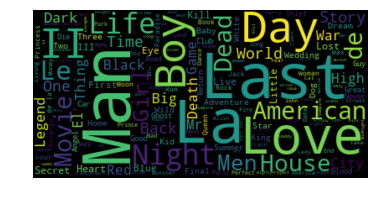

In [20]:
# Exploration original title

# Fill all NAs
missing_val = train['original_title'].isnull().sum()
print(f'{missing_val} data entries without original title')

train['original_title'].fillna('None')
test['original_title'].fillna('None')

# list all movies that contain numbers
films_with_ints = sorted([title for title in train['original_title'] if re.search(r'\d+', title)])

print(f'{len(films_with_ints)} movies have a title that contains one or more integers')

# create a wordcloud
all_org_title = train['original_title'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_org_title)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [21]:
# print some checks to see how the above words are taken into account
print(all_org_title.count('Life'))

word = [x for x in train['original_title'] if 'Life' in x]

print(word)

21
['Boys Life 2', 'Life During Wartime', 'The Mostly Unfabulous Social Life of Ethan Green', 'The Wild Life', 'This Boy’s Life', 'The Private Life of Sherlock Holmes', 'The Book of Life', 'Life of Crime', 'Life of Brian', 'The Death and Life of Bobby Z', 'A Better Life', 'My Life in Ruins', 'The Life of David Gale', 'The Odd Life of Timothy Green', 'Mishima: A Life in Four Chapters', 'The Life Aquatic with Steve Zissou', 'Life As We Know It', 'The Secret Life of Walter Mitty', 'The Life and Death of 9413, a Hollywood Extra', 'Middle School: The Worst Years of My Life', 'The Tree of Life']


#### overview

8 data entries without overview


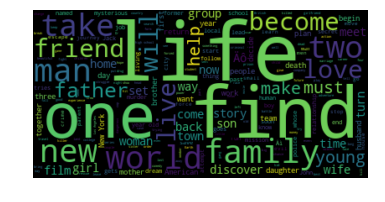

In [22]:
# Explore the overview variable

# Fill all NAs
missing_val = train['overview'].isnull().sum()
print(f'{missing_val} data entries without overview')

train['overview'].fillna('None')
test['overview'].fillna('None')

# Creating word cloud
all_overviews = train['overview'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_overviews)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
# check how many times a word above actually appears in the overviews
print(all_overviews.count('family'))


307


I may take the top 10 (?) words of this word cloud and consider these in my algorithm.

#### tagline

597 data entries without tagline


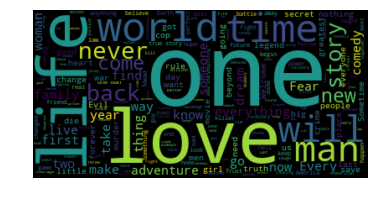

In [24]:
# Explore the tagline variable

# Fill all NAs
missing_val = train['tagline'].isnull().sum()
print(f'{missing_val} data entries without tagline')

train['tagline'].fillna('None')
test['tagline'].fillna('None')

# Creating word cloud
all_tagline = train['tagline'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_tagline)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The tagline could be used in a similar way as the title or overview of a movie. I may consider it.

#### title
I will check how big the difference between title and original title is.

In [25]:
# Exploring the title variable
missing_val = train['title'].isnull().sum()
print(f'{missing_val} data entries without title')

train['title'].fillna('None')
test['title'].fillna('None')

v = train['title']
w = train['original_title']

diff_list_title = [{x: y} for x, y in zip(train['title'] , train['original_title']) if x != y]

print(diff_list_title[:5])


0 data entries without title
[{'Marine Boy': '마린보이'}, {'Skinning': 'Šišanje'}, {'The Intouchables': 'Intouchables'}, {'The Double Hour': 'La doppia ora'}, {'Moscow, Belgium': 'Aanrijding in Moscou'}]


There is a difference of ~12% between the title and original title. Since the title is in English, I will only consider this and not the original title.

193 movies have a title that contains one or more integers


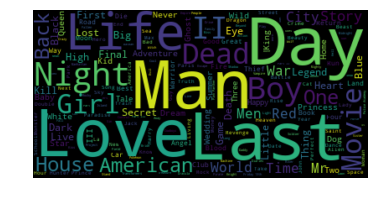

In [26]:
# list all movies that contain numbers
films_with_ints = sorted([title for title in train['title'] if re.search(r'\d+', title)])

print(f'{len(films_with_ints)} movies have a title that contains one or more integers')

# create a wordcloud
all_title = train['title'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_title)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
# Dropping original title variable
train = train.drop('original_title', axis=1)
test = test.drop('original_title', axis=1)


### Numeric variables


#### budget
I'll now take a look at the numerical features of the dataset. The budget figures are not inflation adjusted.

In [28]:
# descriptive statistics for budget variable
print(train['budget'].describe().apply(lambda x: format(x, 'f')))

# print number of NAs
mis_val = train['budget'].isnull().sum()
print('\n', f'{mis_val} values missing from budget variable')

# print number of zeroes which is equivalent to a missing value
zeroes = [x for x in train['budget'] if x == 0]
print('\n', f'{len(zeroes)} values with the value 0 which is equivalent to a missing value')

trim_10_rev = stats.trim_mean(train['budget'], 0.1)
print('\n', f'The 10% trimmed mean is {trim_10_rev}')


count         3000.000000
mean      22531334.110000
std       37026086.411987
min              0.000000
25%              0.000000
50%        8000000.000000
75%       29000000.000000
max      380000000.000000
Name: budget, dtype: object

 0 values missing from budget variable

 812 values with the value 0 which is equivalent to a missing value

 The 10% trimmed mean is 14133389.000833333


C:\Users\julia\Anaconda3\lib\site-packages\scipy\stats\stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)


In [29]:
# creating color variables for upcoming plots
orange = sb.color_palette()[1]
blue = sb.color_palette()[0]
green = sb.color_palette()[2]
red = sb.color_palette()[3]
purple = sb.color_palette()[4]


Budget is a very skewed variable. I will apply a log transformation to ease this bias.

C:\Users\julia\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


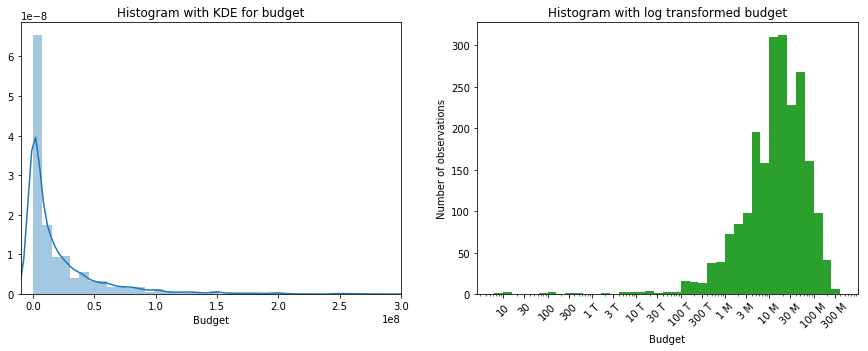

In [30]:
# plotting the budget variable

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
sb.distplot(train['budget'], bins = 50)
plt.xlim(-10000000, 300000000)
plt.xlabel('Budget')
plt.title('Histogram with KDE for budget')

# log transforming the data
plt.subplot(1, 2, 2)
log_data = np.log10(train['budget'] + 1) # add plus 1 to avoid log(0)
plt.xlabel('Budget')
plt.ylabel('Number of observations')
plt.title('Histogram with log transformed budget')
bin_edges = 10 ** np.arange(0.8, np.log10(train['budget'].max()) + 0.2, 0.2)
plt.hist(train['budget'], bins=bin_edges, color = green);
plt.xscale('log')
labels = [10, 30, 100, 300, '1 T', '3 T', '10 T', '30 T', '100 T', '300 T', '1 M', '3 M', '10 M', '30 M', '100 M', '300 M']
tick_locs = [10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000, 300000000]
plt.xticks(tick_locs, labels, rotation=45);


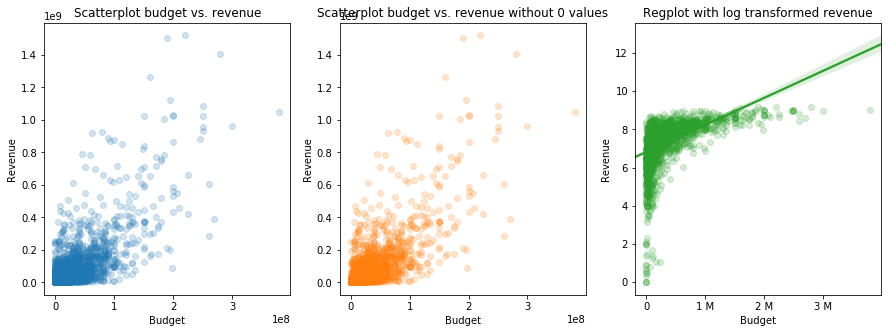

In [31]:
# Scatterplot of budget vs. revenue
fig, axes = plt.subplots(figsize= [15, 5])

plt.subplot(1, 3, 1)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Scatterplot budget vs. revenue')
plt.scatter(data = train, x='budget', y='revenue', alpha = 0.2);

# drop all rows with zeros
train_new = ['budget', 'revenue']
placeholder = train[train_new]
placeholder = placeholder.loc[~(placeholder==0).any(axis=1)]

# scatterplot without the NA/zero values in budget variable
plt.subplot(1, 3, 2)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Scatterplot budget vs. revenue without 0 values')
plt.scatter(placeholder['budget'], placeholder['revenue'], alpha = 0.2, color = orange);

# regplot with log transformation
plt.subplot(1, 3, 3)
sb.regplot(placeholder['budget'], placeholder['revenue'].apply(lambda x: np.log10(x)), scatter_kws={'alpha': 0.2}, color = green);
ax = plt.gca()
ax.set_xticklabels(['0', '0', '1 M', '2 M', '3 M'])
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Regplot with log transformed revenue');



There was only a mild improvement in the scatterplot of budget vs. revenue after removing all rows with values of 0. During the feature transformation section, I will exclude all rows that do not have a budget value. Looking at the regplot with a log transformed revenue (which I applied because the distribution of points appeared to be in the form of log(y) &alpha;	x), there seems to be a moderate non-linear relationship between these two variables.

#### revenue
The revenue figures are not adjusted for inflation, so I am expecting the revenue figures to continuously increase over the years just because of the increase of ticket prices. It is rather difficult to properly adjust revenue for inflation. First of all, ticket prices increased at a different pace than overall inflation. Moreover, there are many instances where a movie was re-released over time, so ticket prices would need to be used to calculate the number of tickets sold at those particular re-release years. It gets messy fairly quickly. I will therefore stick to the unadjusted numbers, the same way I am keeping the budget unadjusted as well.

In [32]:
# get descriptive statistics for revenue variable
print(train['revenue'].describe().apply(lambda x: format(x, 'f')))
mis_val_rev = train['revenue'].isnull().sum().sum()
print('\n', f'{mis_val_rev} entries NA')

trim_10_rev = stats.trim_mean(tuple(train['revenue']), 0.1) # tuple declaration is necessary to avoid warning message
print('\n', f'The 10% trimmed mean is {trim_10_rev}')

count          3000.000000
mean       66725851.888667
std       137532326.336018
min               1.000000
25%         2379808.250000
50%        16807068.000000
75%        68919203.500000
max      1519557910.000000
Name: revenue, dtype: object

 0 entries NA

 The 10% trimmed mean is 35059391.91083334


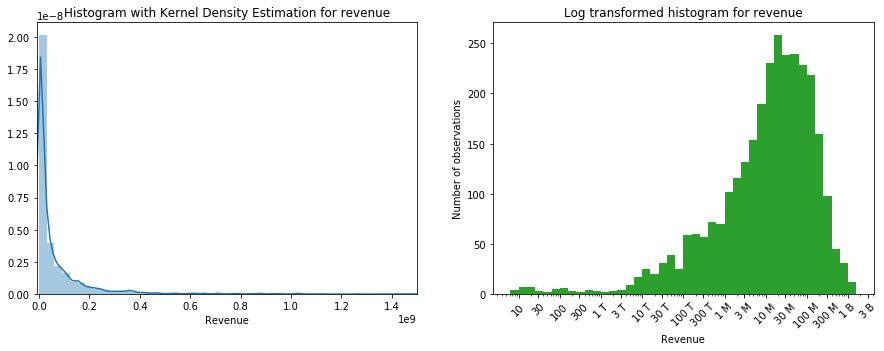

In [33]:
# plotting the revenue variable

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
sb.distplot(train['revenue'], bins = 50)
plt.xlim(-10000000, 1500000000)
plt.xlabel('Revenue')
plt.title('Histogram with Kernel Density Estimation for revenue')

# log transforming the data
plt.subplot(1, 2, 2)
log_data = np.log10(train['revenue'] + 1) # add plus 1 to avoid log(0)
plt.xlabel('Revenue')
plt.ylabel('Number of observations')
plt.title('Log transformed histogram for revenue')
bin_edges = 10 ** np.arange(0.8, np.log10(train['revenue'].max()) + 0.2, 0.2)
plt.hist(train['revenue'], bins=bin_edges, color = green);
plt.xscale('log')
labels = [10, 30, 100, 300, '1 T', '3 T', '10 T', '30 T', '100 T', '300 T', '1 M', '3 M', '10 M', '30 M', '100 M', '300 M', '1 B', '3 B']
tick_locs = [10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000, 300000000, 1000000000, 3000000000]
plt.xticks(tick_locs, labels, rotation=45);


#### popularity

In [34]:
# get descriptive statistics for popularity variable
print(train['popularity'].describe().apply(lambda x: format(x, 'f')))
mis_val_rev = train['popularity'].isnull().sum().sum()
print('\n', f'{mis_val_rev} entries NA')

# print number entries with a value of less than 1
zeroes = [x for x in train['popularity'] if x < 1]
print('\n', f'{len(zeroes)} values that are smaller than 1.', '\n')

# print the ten most popular movies in the train dataset
pop_train = [{x: y} for x, y in zip(train['popularity'] , train['title']) if x > 100]
pop_train_s = sorted(pop_train, key=lambda x: list(x.keys()))[:10]
print(f'Most popular movies in train dataset: {pop_train_s}', '\n')

# print the ten most popular movies in the test dataset
pop_test = [{v: w} for v, w in zip(test['popularity'] , test['title']) if v > 100]
pop_test_s = sorted(pop_test, key=lambda y: list(y.keys()))[:10]
print(f'Most popular movies in test dataset: {pop_test_s}')


count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: object

 0 entries NA

 235 values that are smaller than 1. 

Most popular movies in train dataset: [{123.167259: 'The Dark Knight'}, {146.161786: 'War for the Planet of the Apes'}, {154.80100900000002: 'Gone Girl'}, {185.33099199999998: 'Guardians of the Galaxy Vol. 2'}, {187.860492: 'Deadpool'}, {228.032744: 'Baby Driver'}, {287.253654: 'Beauty and the Beast'}, {294.337037: 'Wonder Woman'}] 

Most popular movies in test dataset: [{133.82782: 'Pirates of the Caribbean: Dead Men Tell No Tales'}, {140.95023600000002: 'Pulp Fiction'}, {145.882135: 'Captain America: Civil War'}, {147.098006: 'The Hunger Games: Mockingjay - Part 1'}, {183.870374: 'John Wick'}, {185.070892: 'Avatar'}, {213.84990699999997: 'Big Hero 6'}, {547.4882980000001: 'Minions'}]


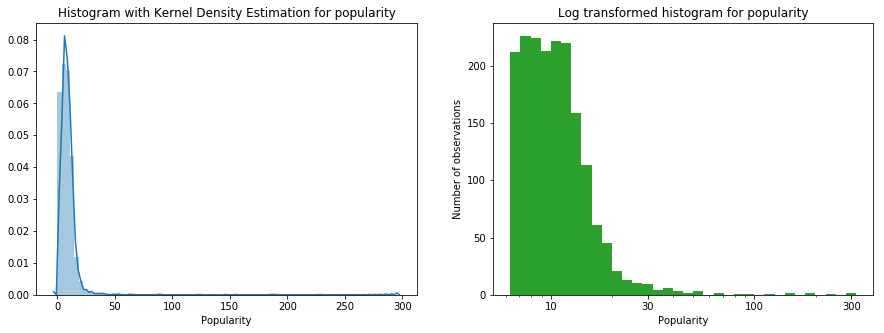

In [35]:
# visual exploration of the popularity variable

# distplot of popularity
plt.figure(figsize = [15, 5])
plt.subplot(1, 2, 1)
sb.distplot(train['popularity'], bins = 80)
plt.xlabel('Popularity')
plt.title('Histogram with Kernel Density Estimation for popularity')

# log transformed histogram
plt.subplot(1, 2, 2)
log_data = np.log10(tuple(train['popularity'] + 1)) # add plus 1 to avoid log(0) and put it into tuple to avoid warning
plt.xlabel('Popularity')
plt.ylabel('Number of observations')
plt.title('Log transformed histogram for popularity')
bin_edges = 10 ** np.arange(0.8, np.log10(train['popularity'].max()) + 0.05, 0.05)
plt.hist(train['popularity'], bins=bin_edges, color = green);
plt.xscale('log')
tick_locs = [10, 30, 100, 300]
plt.xticks(tick_locs, tick_locs,);


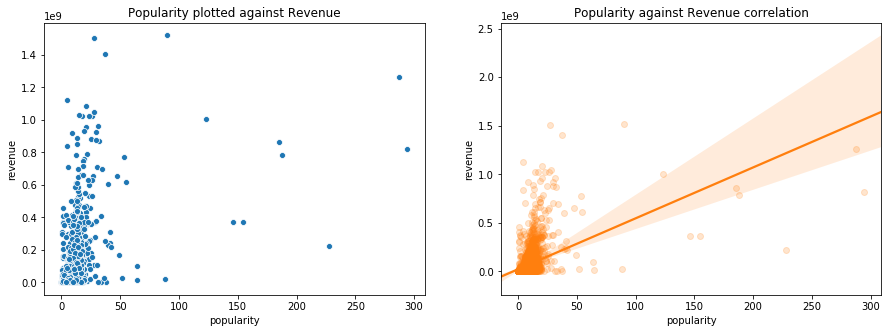

In [36]:
# scatterplot of popularity vs. revenue
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.title('Popularity plotted against Revenue')
sb.scatterplot(data = train, x='popularity', y='revenue')

plt.subplot(1, 2, 2)
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.title('Popularity against Revenue correlation')
sb.regplot(data = train, x='popularity', y='revenue', color = orange, scatter_kws = {'alpha': 0.2});


I actually expected this metric to be similar to a star rating from 1 to 10. However, according to the movie databases [API docs](https://developers.themoviedb.org/3/getting-started/popularity), it is based on a number of different metrics, including number of votes and views for a day. Moreover, according to a [moderator at the TMDB website](https://www.themoviedb.org/talk/5141d424760ee34da71431b0), the lower bound of this value is 0 and the upper bound is technically infinity. The higher the value (and in this sense, it is a ranking), the more popular a title is. For example, the most popular movie title in the train dataset is Wonder Woman. Given the above plots, surprisingly, there seems to be a low correlation between the popularity variable of a movie and the revenue it generates.

#### release date

In [59]:
# get descriptive statistics for release date variable
print(train['release_date'].describe())
mis_val_rev = train['release_date'].isnull().sum().sum()
print('\n', f'{mis_val_rev} entries NA', '\n')

# create new dataframe columns containing only the year and only the month of release
temp_col = ['release_date', 'revenue', 'title']
temp = pd.DataFrame(train[temp_col])

temp['release_year'] = train['release_date'].map(lambda x: str(19) + x[-2:] if int(x[-2:]) > 17 else str(20) + x[-2:])
temp['release_month'] = train['release_date'].map(lambda x: int(x[:2]) if x[1] != '/' else int(x[:1]))

print(temp.head())

count        3000
unique       2398
top       9/10/15
freq            5
Name: release_date, dtype: object

 0 entries NA 

  release_date   revenue                                     title  \
0      2/20/15  12314651                    Hot Tub Time Machine 2   
1       8/6/04  95149435  The Princess Diaries 2: Royal Engagement   
2     10/10/14  13092000                                  Whiplash   
3       3/9/12  16000000                                   Kahaani   
4       2/5/09   3923970                                Marine Boy   

  release_year  release_month  
0         2015              2  
1         2004              8  
2         2014             10  
3         2012              3  
4         2009              2  


The raw release_date data in the train and test files only contain a shortened year format such as '17' or '87'. There is a gap in the years between the years 17 and 21. In order to ensure that 17 actually refers to 2017, I am printing out the movies released in 2017 to do a quick check if they actually were released then (and not in 1917).

In [42]:
# print the movies that were released in '17 to check whether this year relates to 2017 or 1917

seventeen = [x for x, y in zip(temp['title'], temp['release_year']) if int(y) == 2017]

print(seventeen)

['Wilson', "The Zookeeper's Wife", 'Cars 3', 'Chasing Trane', 'The Spacewalker', 'Phoenix Forgotten', "A Dog's Purpose", 'Wonder Woman', 'Unforgettable', 'Sahara', 'Beauty and the Beast', 'Table 19', 'John Wick: Chapter 2', 'Snatched', 'Bairavaa', 'Power Rangers', '2:22', 'Lady Macbeth', 'Song to Song', 'Rescue Under Fire', 'Lovesong', 'The Hero', 'The Ottoman Lieutenant', 'Transformers: The Last Knight', 'Baby Driver', 'War for the Planet of the Apes', 'Black Snow', 'Logan', 'The Mummy', 'Guardians of the Galaxy Vol. 2', 'The Circle', 'Diary of a Wimpy Kid: The Long Haul', 'Their Finest', 'Valerian and the City of a Thousand Planets', 'Get Out', 'The Boss Baby', 'The Wall', 'The Beguiled', 'Rings', 'The Shack']


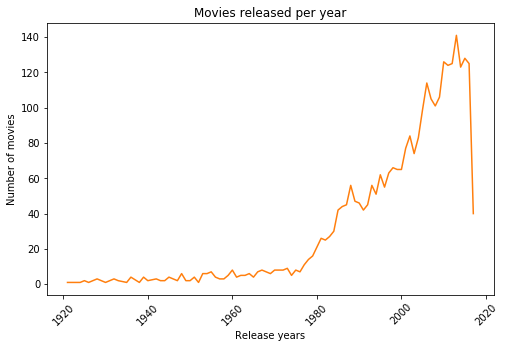

In [43]:
# number of films per year

plt.figure(figsize = [8, 5])

acc_year = temp['release_year'].value_counts().sort_index()

acc_year.index = acc_year.index.values.astype(int)

plt.plot(acc_year.index, acc_year.values, color = orange);
plt.xlabel('Release years')
plt.ylabel('Number of movies')
plt.title('Movies released per year')
plt.xticks(rotation=45);

plt.locator_params(axis='x', nbins=7)

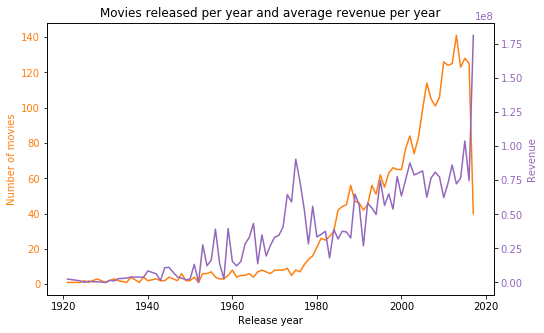

In [44]:
# number of movies released per year and the average revenue per year

fig, ax1 = plt.subplots(figsize = [8, 5])

acc_year = temp['release_year'].value_counts().sort_index()
avg_rev = temp.groupby(['release_year'])['revenue'].mean()

acc_year.index = acc_year.index.values.astype(int)

ax1.plot(acc_year.index, acc_year.values, color = orange)
ax1.set_xlabel('Release year')
ax1.set_ylabel('Number of movies', color = orange)
ax1.tick_params(axis='y', labelcolor = orange)
plt.title('Movies released per year and average revenue per year')

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
# using d1.index as the x values, just like for the y-axis on the left
ax2.plot(acc_year.index, avg_rev.values, color = purple)
ax2.set_ylabel('Revenue', color = purple)
ax2.tick_params(axis='y', labelcolor = purple)


As mentioned before, the revenue and budget figures are not inflation adjusted in this dataset. Because of this large spike of average revenue per film in the 1970s, I want to check whether there is actually some bad data in this data set (namely an inflation adusted revenue figure), so I will take a look at the particular films that were released that year and cross check the numbers with the data from the Box Office Mojo site, which provides inflation adjusted revenue numbers.

In [46]:
# create new dataframe containing accumulated figures
column_corr = ['release_year', 'movies_year', 'avg_rev_year']

corr = pd.DataFrame(columns = [column_corr])

corr['release_year'] = sorted(set(temp['release_year']))
corr['movies_year'] = acc_year.values
corr['avg_rev_year'] = avg_rev.values

print(corr.head())

  release_year movies_year avg_rev_year
0         1921           1    2500000.0
1         1924           1    1213880.0
2         1925           2      22550.5
3         1926           1     966878.0
4         1927           2     513939.0


In [48]:
# print if movies were release in certain year

top_gross_mov = [{y['release_year'][0]: '{0:,.2f}'.format(y['avg_rev_year'][0])} for x, y in corr.iterrows() if float(y['avg_rev_year']) > 80000000]
print(top_gross_mov, '\n')

movies_1975 = [{y['title']: '{0:,}'.format(y['revenue'])} for x, y in temp.iterrows() if float(y['release_year']) == 1975]
print(movies_1975)

[{'1975': '90,480,379.50'}, {'2002': '87,773,835.64'}, {'2004': '80,308,074.69'}, {'2005': '81,908,092.21'}, {'2008': '80,945,077.79'}, {'2012': '86,166,013.78'}, {'2015': '103,854,185.98'}, {'2017': '181,403,935.10'}] 

[{'The Return of the Pink Panther': '41,833,347'}, {'Jaws': '470,654,000'}, {'Cry, Onion!': '39,598,448'}, {'Rooster Cogburn': '8,022,000'}, {'Breakout': '16,000,000'}, {'The Great Waldo Pepper': '20,642,922'}, {'The Rocky Horror Picture Show': '112,892,319'}, {'The Eiger Sanction': '14,200,000'}]


By manual comparison (for now), the numbers of these movies in 1975 are not inflation adjusted. The big outlier is Jaws with USD470 million but this is indeed the unadjusted gross figure. I will now take a look at the correlation between release month and the revenue.

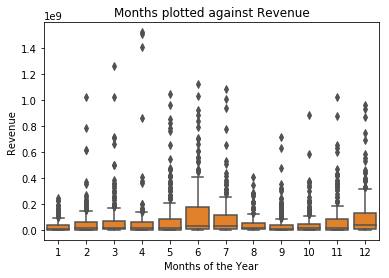

In [88]:
sb.boxplot(x='release_month', y='revenue', data = temp, color = orange)
plt.xlabel('Months of the Year')
plt.ylabel('Revenue')
plt.title('Months plotted against Revenue');

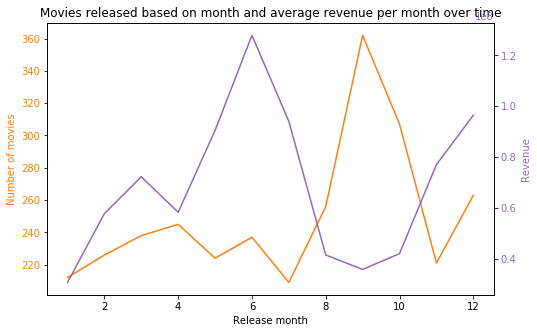

In [89]:
# revenue by month of year
fig, ax1 = plt.subplots(figsize = [8, 5])

acc_month = temp['release_month'].value_counts().sort_index()
avg_rev_month = temp.groupby(['release_month'])['revenue'].mean()

acc_month.index = acc_month.index.values.astype(int)

ax1.plot(acc_month.index, acc_month.values, color = orange)
ax1.set_xlabel('Release month')
ax1.set_ylabel('Number of movies', color = orange)
ax1.tick_params(axis='y', labelcolor = orange)
plt.title('Movies released based on month and average revenue per month over time')

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
# using d1.index as the x values, just like for the y-axis on the left
ax2.plot(acc_month.index, avg_rev_month.values, color = purple)
ax2.set_ylabel('Revenue', color = purple)
ax2.tick_params(axis='y', labelcolor = purple)

While the most movies are released in September and October, the highest average revenue is generated in June, July, and December. The boxplot above shows that the highest grossing movies were actually released in April. Based on the above plots, the release month may be predictive of revenue.

In [ ]:
corr, p_value = pearsonr(corr['movies_year'], corr['avg_rev_year'])
print(corr)

#### runtime

# Feature Engineering

In the sections below, I will clean and transform all variables I want to consider for the prediction of revenue.

I will start by first breaking up the dictionary variables and storing each unique result in a list corresponding to the columns.

In [ ]:
# breakup the dictionary variables
def list_breakdown(data, header):
    all_list = {}
    all_list = {i['name'] for row in data[header] for i in row if row != {}}
    
    return sorted(all_list)
                       

In [ ]:
# create lists with all possible data points for the 8 dictionary variables
all_keywords = list_breakdown(train, 'Keywords')
all_cast = list_breakdown(train, 'cast')
all_crew = list_breakdown(train, 'crew')
all_lang = list_breakdown(train, 'spoken_languages')
all_product_comp = list_breakdown(train, 'production_companies')
all_product_count = list_breakdown(train, 'production_countries')
all_genres = list_breakdown(train, 'genres')
all_collections = list_breakdown(train, 'belongs_to_collection')

print(all_genres)
print(len(all_genres))


In order to one-hot encode my categorical variables, I first need to store the values currently in dictionary format into a string with each individual name separated by commas. This will then allow me to use str.get_dummies(sep=',') to one-hot encode these variables.

In [ ]:
# replace dictionaries by lists with only names for all variables in na_headers
na_headers = pd.Series(na_headers)

def formatting_dict_vars(dataset, headers):
    '''
    input is a dataframe and a list of column headers whose contents need
    to be transformed
    '''
    # create temporary columns
    temp_names = list(map(lambda x: x+'_temp', na_headers))
    for header in temp_names:
        train[header] = 0
    
    # transform dicts into lists containing only the names
    j = 0
    for org_header in headers:
        train[temp_names[j]] = train[org_header].apply(lambda x: ','.join([i['name'] for i in x]) if x != {} else '')
        j += 1
        
    return dataset

train = formatting_dict_vars(train, na_headers)


In [ ]:
# one-hot encode all categorical variables
one_hot = train['genres_temp'].str.get_dummies(sep=',')

train = train.drop('genres_temp', axis = 1)
train = train.join(one_hot)

train.head()

In [ ]:
# log transforming any skewed numeric variables
#skewed = ['', 'capital-loss']
#features_log_transformed = pd.DataFrame(data = features_raw)
#features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

## Analysis ideas
Could be interesting to look at:
* correlation between month of release and revenue
* question: do I need to account for inflation when looking at the revenue made from movies? --> they are not inflation adjusted